# Demo: Convolutional neural network (CNN) using PyTorch


This tutoriel is based on this one : https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import colors
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.__version__

'2.3.1+cu121'

In [3]:
# !pip install torchsummary
# !pip install torchinfo
from torchinfo import summary
import torchvision
from torchvision import transforms, datasets

## I. Presenting the API

In [4]:
test_in_img1 = []

for i in range(6): # rows
    row = []
    test_in_img1.append(row)
    for j in range(5): # columns
        nb = i * 5 + j
        row.append([nb, nb + 100])

test_in = torch.tensor([test_in_img1], dtype=torch.float32)

print(test_in.shape)

# This example is channel last
test_in

torch.Size([1, 6, 5, 2])


tensor([[[[  0., 100.],
          [  1., 101.],
          [  2., 102.],
          [  3., 103.],
          [  4., 104.]],

         [[  5., 105.],
          [  6., 106.],
          [  7., 107.],
          [  8., 108.],
          [  9., 109.]],

         [[ 10., 110.],
          [ 11., 111.],
          [ 12., 112.],
          [ 13., 113.],
          [ 14., 114.]],

         [[ 15., 115.],
          [ 16., 116.],
          [ 17., 117.],
          [ 18., 118.],
          [ 19., 119.]],

         [[ 20., 120.],
          [ 21., 121.],
          [ 22., 122.],
          [ 23., 123.],
          [ 24., 124.]],

         [[ 25., 125.],
          [ 26., 126.],
          [ 27., 127.],
          [ 28., 128.],
          [ 29., 129.]]]])

### I.1. Convolution

In [5]:
conv2d_model = nn.Sequential(
    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3, 3), stride=(1, 1)),
    nn.ReLU()
)#.to(memory_format=torch.channels_last) #by default channels are first

# parameters number is [3 (H) * 3 (W) * 2 (d) + 1 ] * 4 (k) = 76

summary(conv2d_model, input_size=(2, 6, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [4, 4, 3]                 --
├─Conv2d: 1-1                            [4, 4, 3]                 76
├─ReLU: 1-2                              [4, 4, 3]                 --
Total params: 76
Trainable params: 76
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [6]:
conv2d_model.eval()

with torch.no_grad():
    test_out = conv2d_model(test_in.permute(0, 3, 1, 2))

# H' = (H - Hf + 2P)/S + 1 = (6 - 3 + (2 * 0))/1 + 1 = 4
# W' = (W - Wf + 2P)/S + 1 = (5 - 3 + (2 * 0))/1 + 1 = 3
# shape = (M, H', W', k) = (1, 4, 3, 4) channel last
# shape = (M, k, H', W') = (1, 4, 4, 3) channel first
test_out

tensor([[[[3.8596e+00, 3.3129e+00, 2.7663e+00],
          [1.1264e+00, 5.7978e-01, 3.3157e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[5.1707e+01, 5.2908e+01, 5.4110e+01],
          [5.7713e+01, 5.8915e+01, 6.0116e+01],
          [6.3719e+01, 6.4921e+01, 6.6122e+01],
          [6.9726e+01, 7.0927e+01, 7.2128e+01]],

         [[3.7159e+00, 3.6422e+00, 3.5684e+00],
          [3.3472e+00, 3.2734e+00, 3.1997e+00],
          [2.9784e+00, 2.9047e+00, 2.8309e+00],
          [2.6097e+00, 2.5359e+00, 2.4622e+00]]]])

### I.2. Max Pool

In [7]:
maxpool2d_model = nn.Sequential(
    nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))
)

# parameters numer is zero

summary(maxpool2d_model, input_size=(2, 6, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [2, 4, 3]                 --
├─MaxPool2d: 1-1                         [2, 4, 3]                 --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [8]:
maxpool2d_model.eval()

with torch.no_grad():
    test_out = maxpool2d_model(test_in.permute(0, 3, 1, 2))

# H' = (H - Hf + 2P)/S + 1 = (6 - 3 + (2 * 0))/1 + 1 = 4
# W' = (W - Wf + 2P)/S + 1 = (5 - 3 + (2 * 0))/1 + 1 = 3
# shape = (M, H', W', k) = (1, 4, 3, 4) channel last
# shape = (M, k, H', W') = (1, 4, 4, 3) channel first
test_out

tensor([[[[ 12.,  13.,  14.],
          [ 17.,  18.,  19.],
          [ 22.,  23.,  24.],
          [ 27.,  28.,  29.]],

         [[112., 113., 114.],
          [117., 118., 119.],
          [122., 123., 124.],
          [127., 128., 129.]]]])

### I.3. Average Pool

In [9]:
avgpool2d_model = nn.Sequential(
    nn.AvgPool2d(kernel_size=(3, 3), stride=(1, 1))
)

# parameters numer is zero

summary(avgpool2d_model, input_size=(2, 6, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [2, 4, 3]                 --
├─AvgPool2d: 1-1                         [2, 4, 3]                 --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [10]:
avgpool2d_model.eval()

with torch.no_grad():
    test_out = avgpool2d_model(test_in.permute(0, 3, 1, 2))

# H' = (H - Hf + 2P)/S + 1 = (6 - 3 + (2 * 0))/1 + 1 = 4
# W' = (W - Wf + 2P)/S + 1 = (5 - 3 + (2 * 0))/1 + 1 = 3
# shape = (M, H', W', k) = (1, 4, 3, 4) channel last
# shape = (M, k, H', W') = (1, 4, 4, 3) channel first
test_out

tensor([[[[  6.,   7.,   8.],
          [ 11.,  12.,  13.],
          [ 16.,  17.,  18.],
          [ 21.,  22.,  23.]],

         [[106., 107., 108.],
          [111., 112., 113.],
          [116., 117., 118.],
          [121., 122., 123.]]]])

### I.4. Up Sampling

"mode" parameter: A string, one of 'nearest', 'linear', 'bilinear', 'bicubic' and 'trilinear' are allowed.

In [11]:
upsamp2d_model = nn.Sequential(
    nn.Upsample(scale_factor=(2, 2), mode='nearest')
)

# parameters number is zero

summary(upsamp2d_model, input_size=(2, 6, 5))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [12]:
upsamp2d_model.eval()

with torch.no_grad():
    test_out = upsamp2d_model(test_in.permute(0, 3, 1, 2))

# W' = W * Wf = 5 * 2 = 10
# H' = H * Hf = 6 * 2 = 12

print(test_out.shape)
test_out

torch.Size([1, 2, 12, 10])


tensor([[[[  0.,   0.,   1.,   1.,   2.,   2.,   3.,   3.,   4.,   4.],
          [  0.,   0.,   1.,   1.,   2.,   2.,   3.,   3.,   4.,   4.],
          [  5.,   5.,   6.,   6.,   7.,   7.,   8.,   8.,   9.,   9.],
          [  5.,   5.,   6.,   6.,   7.,   7.,   8.,   8.,   9.,   9.],
          [ 10.,  10.,  11.,  11.,  12.,  12.,  13.,  13.,  14.,  14.],
          [ 10.,  10.,  11.,  11.,  12.,  12.,  13.,  13.,  14.,  14.],
          [ 15.,  15.,  16.,  16.,  17.,  17.,  18.,  18.,  19.,  19.],
          [ 15.,  15.,  16.,  16.,  17.,  17.,  18.,  18.,  19.,  19.],
          [ 20.,  20.,  21.,  21.,  22.,  22.,  23.,  23.,  24.,  24.],
          [ 20.,  20.,  21.,  21.,  22.,  22.,  23.,  23.,  24.,  24.],
          [ 25.,  25.,  26.,  26.,  27.,  27.,  28.,  28.,  29.,  29.],
          [ 25.,  25.,  26.,  26.,  27.,  27.,  28.,  28.,  29.,  29.]],

         [[100., 100., 101., 101., 102., 102., 103., 103., 104., 104.],
          [100., 100., 101., 101., 102., 102., 103., 103., 104

## II. CNN classifier

### II.1. dataset

In [13]:
# 1. Download MNIST and normalize
transform = transforms.Compose([
    transforms.ToTensor(),                
])

train_dataset = datasets.MNIST(root='~/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/data', train=False, download=True, transform=transform)

# 2. Convert to tensors
x_train = train_dataset.data.unsqueeze(1).float() / 255.0  # Shape: (60000, 1, 28, 28)
y_train = train_dataset.targets               # Shape: (60000,)

x_test = test_dataset.data.unsqueeze(1).float() / 255.0    # Shape: (10000, 1, 28, 28)
y_test = test_dataset.targets                 # Shape: (10000,)

# 3. Reshape from (N, 28, 28) to (N, 784)
x_train1 = x_train.view(-1, 784)  # Shape: (60000, 784)
x_test1 = x_test.view(-1, 784)    # Shape: (10000, 784)

# 4. One-hot encode the labels
y_train_onehot = F.one_hot(y_train, num_classes=10).float()  # Shape: (60000, 10)
y_test_onehot = F.one_hot(y_test, num_classes=10).float()    # Shape: (10000, 10)

x_train.shape, x_test.shape, x_train1.shape, x_test1.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000, 784]),
 torch.Size([10000, 784]))

### II.2. FFNN classifier

In [14]:
torch.manual_seed(0)
ffnn_cls = nn.Sequential()
ffnn_cls.append(nn.Linear(784, 30))
ffnn_cls.append(nn.ReLU())
ffnn_cls.append(nn.Dropout(0.2))
ffnn_cls.append(nn.Linear(30, 10))
ffnn_cls.append(nn.Softmax(dim=-1))


summary(ffnn_cls)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            23,550
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            310
├─Softmax: 1-5                           --
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0

In [15]:
class Trainer:
    def __init__(self, model, loss, optimizer, classif=True):
        self.model = model
        self.loss = loss 
        self.optimizer = optimizer
        self.classif = classif

    def fit(self, train_loader, epochs= 10, test_loader=None):
        history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
        for epoch in range(epochs):
            self.model.train()
            loss_trn, correct_trn, total_trn = 0, 0, 0
            for x_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(x_batch)
                if self.classif:
                    loss = self.loss(outputs, torch.argmax(y_batch, dim=1))
                    preds = torch.argmax(outputs, dim=1)
                    correct_trn += (preds == torch.argmax(y_batch, dim=1)).sum().item()
                else:
                    loss = self.loss(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

                loss_trn += loss.item() * x_batch.size(0)
                total_trn += x_batch.size(0)

            print_str = ''
            if self.classif:
                acc_trn = correct_trn / total_trn
                history['accuracy'].append(acc_trn)
                print_str += f", accuracy: {acc_trn:.4f}"
            loss_trn = loss_trn/total_trn
            history['loss'].append(loss_trn)
            print_str += f", loss: {loss_trn:.4f}"
            
            if test_loader is not None:
                loss_val, correct_val, total_val = 0, 0, 0
                with torch.no_grad():
                    self.model.eval()
                    correct_val, total_val = 0, 0
                    for x_batch, y_batch in test_loader:
                        outputs = self.model(x_batch)
                        if self.classif:
                            loss = self.loss(outputs, torch.argmax(y_batch, dim=1))
                            preds = torch.argmax(outputs, dim=1)
                            correct_val += (preds == torch.argmax(y_batch, dim=1)).sum().item()
                        else:
                            loss = self.loss(outputs, y_batch)
                        loss_val += loss.item() * x_batch.size(0)
                        total_val += x_batch.size(0)
                
                if self.classif:
                    acc_val = correct_val / total_val
                    history['val_accuracy'].append(acc_val)
                    print_str += f", val_accuracy: {acc_val:.4f}"
                loss_val = loss_val/total_val
                history['val_loss'].append(loss_val)
                print_str += f", val_loss: {loss_val:.4f}"

            print(f"Epoch {epoch+1}/{epochs}" + print_str)
        
        return history

In [17]:
print("Training FFNN classifier ...")
train_loader = DataLoader(TensorDataset(x_train1, y_train_onehot), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test1, y_test_onehot), batch_size=32, shuffle=False)

ffnn_cls_trainer = Trainer(ffnn_cls, nn.CrossEntropyLoss(), optim.Adam(ffnn_cls.parameters()))

ffnn_hist = ffnn_cls_trainer.fit(train_loader, epochs=50, test_loader=test_loader)


Training FFNN classifier ...
Epoch 1/50, accuracy: 0.9023, loss: 1.5690, val_accuracy: 0.9293, val_loss: 1.5383
Epoch 2/50, accuracy: 0.9161, loss: 1.5528, val_accuracy: 0.9385, val_loss: 1.5266
Epoch 3/50, accuracy: 0.9215, loss: 1.5454, val_accuracy: 0.9427, val_loss: 1.5225
Epoch 4/50, accuracy: 0.9265, loss: 1.5403, val_accuracy: 0.9458, val_loss: 1.5187
Epoch 5/50, accuracy: 0.9280, loss: 1.5375, val_accuracy: 0.9474, val_loss: 1.5166
Epoch 6/50, accuracy: 0.9307, loss: 1.5343, val_accuracy: 0.9470, val_loss: 1.5164
Epoch 7/50, accuracy: 0.9339, loss: 1.5310, val_accuracy: 0.9499, val_loss: 1.5133
Epoch 8/50, accuracy: 0.9345, loss: 1.5300, val_accuracy: 0.9522, val_loss: 1.5115
Epoch 9/50, accuracy: 0.9362, loss: 1.5281, val_accuracy: 0.9518, val_loss: 1.5110
Epoch 10/50, accuracy: 0.9379, loss: 1.5264, val_accuracy: 0.9530, val_loss: 1.5101
Epoch 11/50, accuracy: 0.9394, loss: 1.5248, val_accuracy: 0.9519, val_loss: 1.5104
Epoch 12/50, accuracy: 0.9405, loss: 1.5235, val_accurac

### II.3. CNN classifier

In [18]:
cnn_cls = nn.Sequential()
cnn_cls.append(nn.Conv2d(in_channels=1, out_channels=5, kernel_size=4))
cnn_cls.append(nn.ReLU())
cnn_cls.append(nn.AvgPool2d(kernel_size=5))
cnn_cls.append(nn.Conv2d(in_channels=5, out_channels=2, kernel_size=2))
cnn_cls.append(nn.ReLU())
cnn_cls.append(nn.Flatten())
cnn_cls.append(nn.Linear(32, 10))
cnn_cls.append(nn.Softmax(dim=-1))

summary(cnn_cls, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 5, 25, 25]            85
├─ReLU: 1-2                              [1, 5, 25, 25]            --
├─AvgPool2d: 1-3                         [1, 5, 5, 5]              --
├─Conv2d: 1-4                            [1, 2, 4, 4]              42
├─ReLU: 1-5                              [1, 2, 4, 4]              --
├─Flatten: 1-6                           [1, 32]                   --
├─Linear: 1-7                            [1, 10]                   330
├─Softmax: 1-8                           [1, 10]                   --
Total params: 457
Trainable params: 457
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [19]:
print("Training CNN classifier ...")

train_loader = DataLoader(TensorDataset(x_train, y_train_onehot), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test_onehot), batch_size=32, shuffle=False)

cnn_cls_trainer = Trainer(cnn_cls, nn.CrossEntropyLoss(), optim.Adam(cnn_cls.parameters()))

cnn_hist = cnn_cls_trainer.fit(train_loader, epochs=50, test_loader=test_loader)


Training CNN classifier ...
Epoch 1/50, accuracy: 0.6570, loss: 1.8266, val_accuracy: 0.7399, val_loss: 1.7259
Epoch 2/50, accuracy: 0.7386, loss: 1.7240, val_accuracy: 0.7517, val_loss: 1.7117
Epoch 3/50, accuracy: 0.7493, loss: 1.7131, val_accuracy: 0.7566, val_loss: 1.7063
Epoch 4/50, accuracy: 0.7560, loss: 1.7057, val_accuracy: 0.7633, val_loss: 1.6989
Epoch 5/50, accuracy: 0.7611, loss: 1.7010, val_accuracy: 0.7662, val_loss: 1.6957
Epoch 6/50, accuracy: 0.7641, loss: 1.6975, val_accuracy: 0.7668, val_loss: 1.6947
Epoch 7/50, accuracy: 0.7659, loss: 1.6956, val_accuracy: 0.7665, val_loss: 1.6943
Epoch 8/50, accuracy: 0.7668, loss: 1.6944, val_accuracy: 0.7708, val_loss: 1.6912
Epoch 9/50, accuracy: 0.7682, loss: 1.6930, val_accuracy: 0.7713, val_loss: 1.6896
Epoch 10/50, accuracy: 0.7688, loss: 1.6920, val_accuracy: 0.7721, val_loss: 1.6890
Epoch 11/50, accuracy: 0.8353, loss: 1.6283, val_accuracy: 0.8473, val_loss: 1.6158
Epoch 12/50, accuracy: 0.8481, loss: 1.6149, val_accuracy

### II.4. FFNN vs. CNN classifier

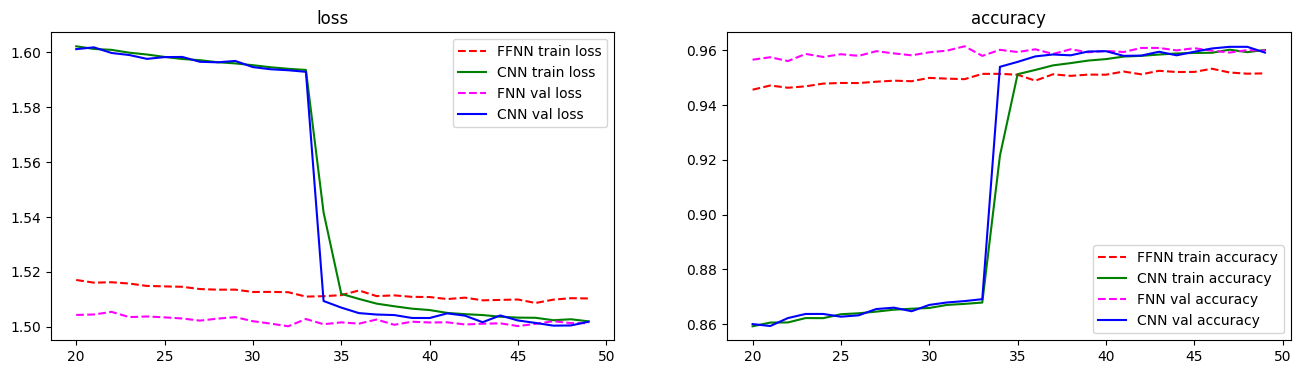

In [20]:
epochs = range(50)
start = 20

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

ax[0].plot(epochs[start:], ffnn_hist["loss"][start:], color="red", linestyle="--", label="FFNN train loss")
ax[0].plot(epochs[start:], cnn_hist["loss"][start:], color="green", label="CNN train loss")
ax[0].plot(epochs[start:], ffnn_hist["val_loss"][start:], color="magenta", linestyle="--", label="FNN val loss")
ax[0].plot(epochs[start:], cnn_hist["val_loss"][start:], color="blue", label="CNN val loss")
ax[0].set_title("loss")
ax[0].legend()

ax[1].plot(epochs[start:], ffnn_hist["accuracy"][start:], color="red", linestyle="--", label="FFNN train accuracy")
ax[1].plot(epochs[start:], cnn_hist["accuracy"][start:], color="green", label="CNN train accuracy")
ax[1].plot(epochs[start:], ffnn_hist["val_accuracy"][start:], color="magenta", linestyle="--", label="FNN val accuracy")
ax[1].plot(epochs[start:], cnn_hist["val_accuracy"][start:], color="blue", label="CNN val accuracy")
ax[1].set_title("accuracy")
ax[1].legend()

plt.show()

## III. CNN auto-encoder

In [21]:
# Encoder 
# ========

encoder_cnnae = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),  # Same padding
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4),                               # (7, 7, 3)
    nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3),             # (5, 5, 1)
    nn.ReLU(),
    nn.Flatten(),                                                       # Flatten to 25
    nn.Linear(25, 2)                                                    # Output: 2D latent space
)

summary(encoder_cnnae, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 3, 28, 28]            30
├─ReLU: 1-2                              [1, 3, 28, 28]            --
├─MaxPool2d: 1-3                         [1, 3, 7, 7]              --
├─Conv2d: 1-4                            [1, 1, 5, 5]              28
├─ReLU: 1-5                              [1, 1, 5, 5]              --
├─Flatten: 1-6                           [1, 25]                   --
├─Linear: 1-7                            [1, 2]                    52
Total params: 110
Trainable params: 110
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [22]:
# Decoder 
# ========

decoder_cnnae = nn.Sequential(
    nn.Linear(2, 25),                          # Dense(2 -> 25)
    nn.ReLU(),
    nn.Unflatten(1, (1, 5, 5)),                # Reshape (5, 5, 1)
    nn.Upsample(scale_factor=2, mode='nearest'),  # (10, 10, 1)
    nn.Conv2d(1, 3, kernel_size=4),            # (7, 7, 3)
    nn.ReLU(),
    nn.Upsample(scale_factor=4, mode='nearest'),  # (28, 28, 3)
    nn.Conv2d(3, 1, kernel_size=3, padding=1), # (28, 28, 1)
    nn.Sigmoid()                              # Output activation
)

summary(decoder_cnnae, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1, 28, 28]            --
├─Linear: 1-1                            [1, 25]                   75
├─ReLU: 1-2                              [1, 25]                   --
├─Unflatten: 1-3                         [1, 1, 5, 5]              --
├─Upsample: 1-4                          [1, 1, 10, 10]            --
├─Conv2d: 1-5                            [1, 3, 7, 7]              51
├─ReLU: 1-6                              [1, 3, 7, 7]              --
├─Upsample: 1-7                          [1, 3, 28, 28]            --
├─Conv2d: 1-8                            [1, 1, 28, 28]            28
├─Sigmoid: 1-9                           [1, 1, 28, 28]            --
Total params: 154
Trainable params: 154
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [23]:
cnnae = nn.Sequential(encoder_cnnae, decoder_cnnae)

summary(cnnae, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 3, 28, 28]            30
│    └─ReLU: 2-2                         [1, 3, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 3, 7, 7]              --
│    └─Conv2d: 2-4                       [1, 1, 5, 5]              28
│    └─ReLU: 2-5                         [1, 1, 5, 5]              --
│    └─Flatten: 2-6                      [1, 25]                   --
│    └─Linear: 2-7                       [1, 2]                    52
├─Sequential: 1-2                        [1, 1, 28, 28]            --
│    └─Linear: 2-8                       [1, 25]                   75
│    └─ReLU: 2-9                         [1, 25]                   --
│    └─Unflatten: 2-10                   [1, 1, 5, 5]              --
│    └─Upsample

In [24]:
# we can train it on a problem of regression

train_loader = DataLoader(TensorDataset(x_train, x_train), batch_size=32, shuffle=True)

cnnae_trainer = Trainer(cnnae, nn.MSELoss(), optim.Adam(cnnae.parameters()), classif=False)

cnnae_hist = cnnae_trainer.fit(train_loader, epochs=20)

Epoch 1/20, loss: 0.0712
Epoch 2/20, loss: 0.0627
Epoch 3/20, loss: 0.0611
Epoch 4/20, loss: 0.0605
Epoch 5/20, loss: 0.0603
Epoch 6/20, loss: 0.0601
Epoch 7/20, loss: 0.0600
Epoch 8/20, loss: 0.0599
Epoch 9/20, loss: 0.0598
Epoch 10/20, loss: 0.0598
Epoch 11/20, loss: 0.0598
Epoch 12/20, loss: 0.0597
Epoch 13/20, loss: 0.0597
Epoch 14/20, loss: 0.0596
Epoch 15/20, loss: 0.0596
Epoch 16/20, loss: 0.0595
Epoch 17/20, loss: 0.0593
Epoch 18/20, loss: 0.0592
Epoch 19/20, loss: 0.0592
Epoch 20/20, loss: 0.0592


In [25]:
# encode the samples into two dimension representation
encoded_imgs = encoder_cnnae(x_train)

print(encoded_imgs.shape)

torch.Size([60000, 2])


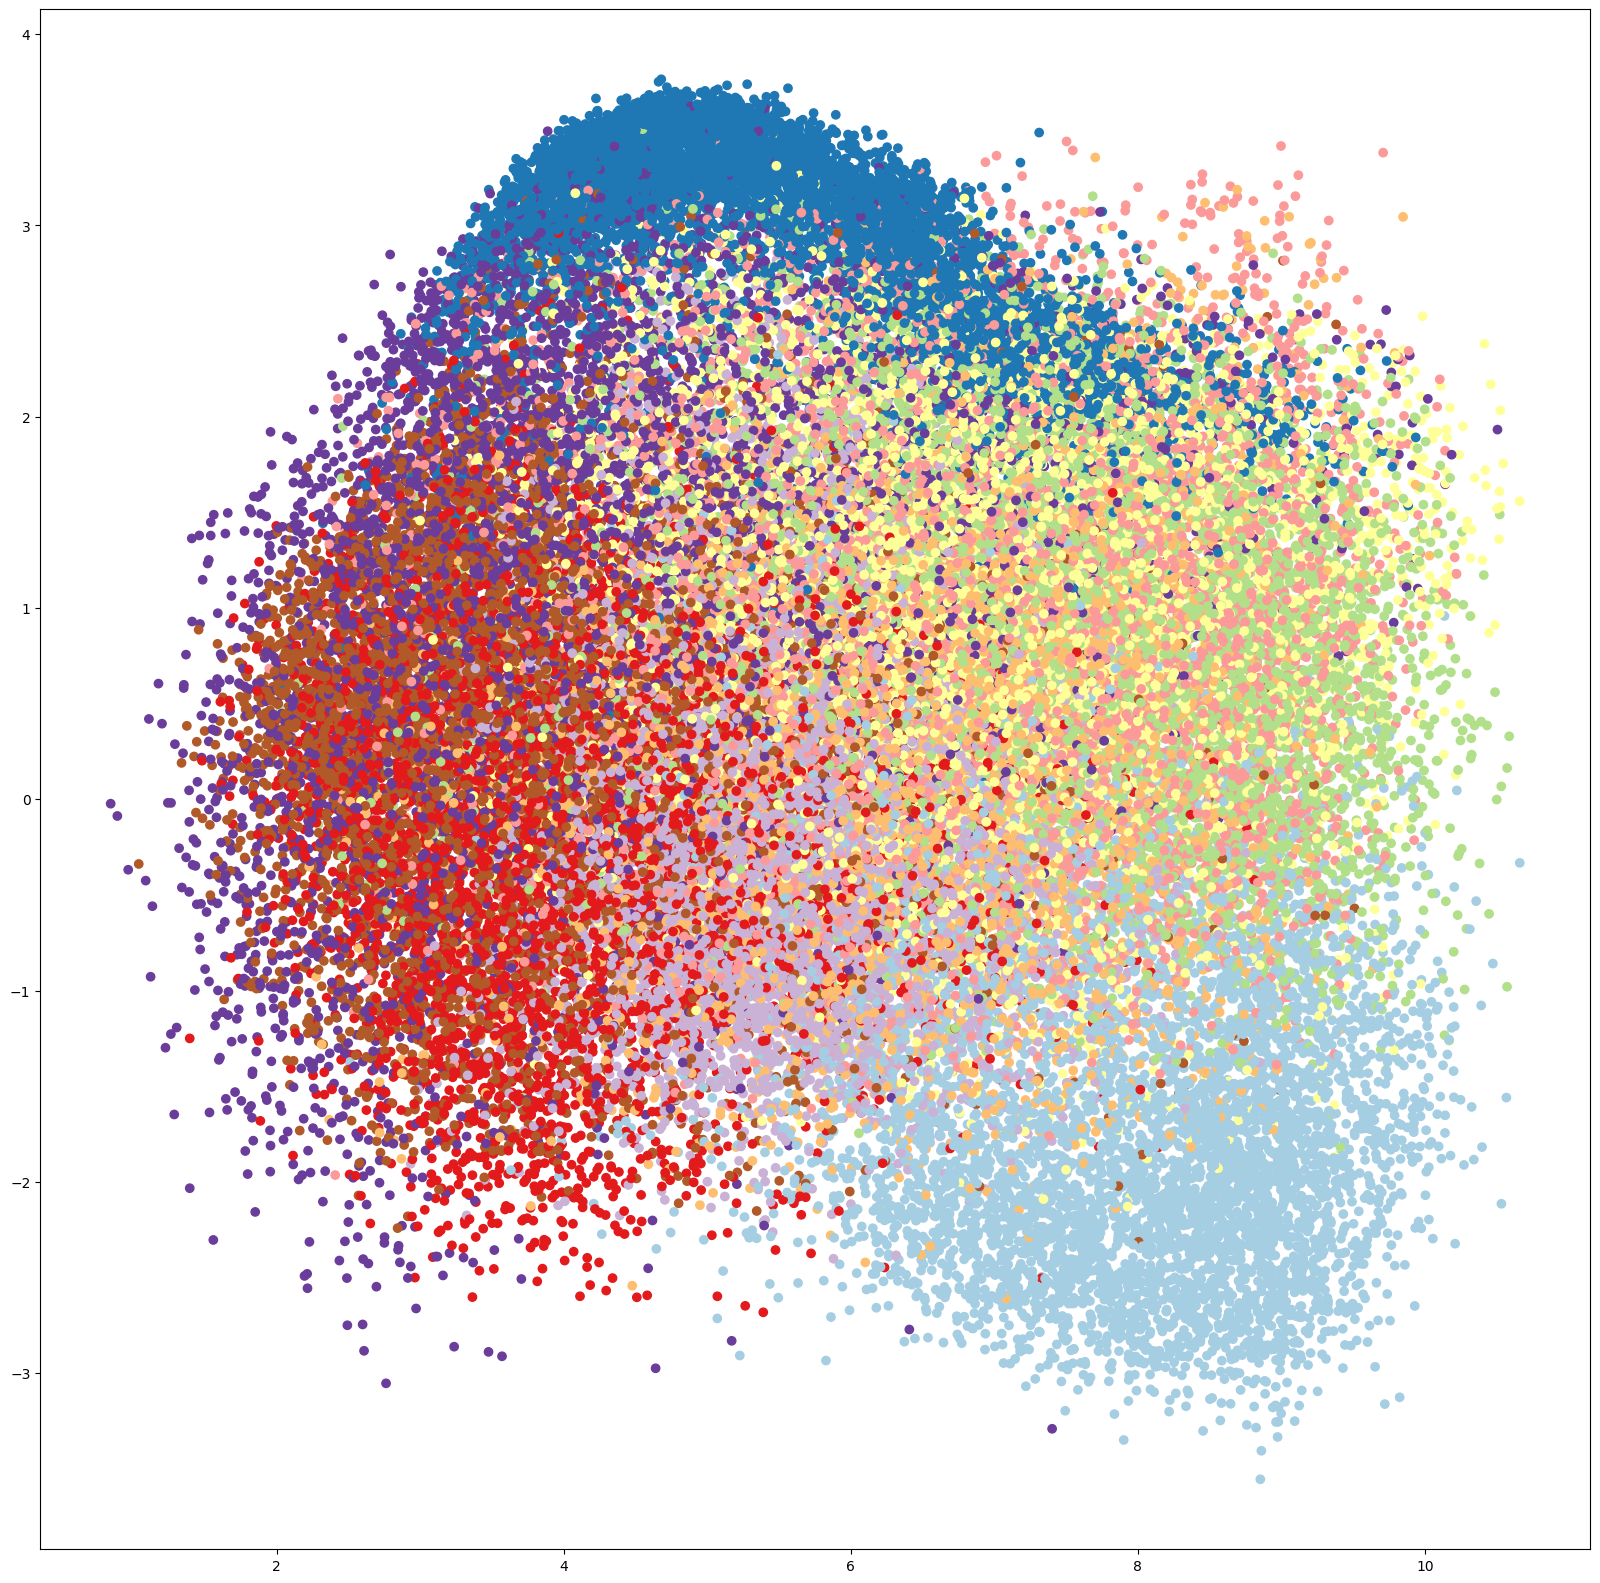

In [26]:
# plot the distribution of samples using the codes learned using the auto-encoder
# Each color represents a number
plt.figure(figsize=(20, 20))
plt.scatter(encoded_imgs[:, 0].detach().numpy(), encoded_imgs[:, 1].detach().numpy(), c=y_train, cmap = plt.cm.Paired)

In [27]:
# a function that plots some reconstructed numbers based on 
# an interval of values on x and y
# model: this is the encoder model
# nx: this is the number of values we chose over x
# ny: this is the number of values we chose over y
# interval: a tuple (min_x, min_y, max_x,max_y)
def draw_generated_images(model, nx, ny, interval):
    min_x, min_y, max_x, max_y = interval
    # generate a vector x of nx elements which the values are between min_x and max_x
    grid_x = np.linspace(min_x, max_x, nx) 
    # generate a vector y of ny elements which the values are between min_y and max_y
    grid_y = np.linspace(min_y, max_y, ny)
    
    # generate some codes by combining all values of x and y
    codes = torch.tensor(np.meshgrid(grid_x, grid_y), dtype=torch.float32).T.reshape(-1, 2)
    # predict the image based on the codes 
    decoded_imgs = model(codes)

    plt.figure(figsize=(20, 4))
    for xi in range(nx):
        for yi in range(ny): 
            i = yi * nx + xi
            #print(i)
            ax = plt.subplot(ny, nx, i + 1)
            plt.imshow(decoded_imgs[i].reshape(28, 28).detach().numpy())
            plt.gray()
            #plt.title(str(codes[i]))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
print('function defined')

function defined


/tmp/ipykernel_514954/3364134858.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  codes = torch.tensor(np.meshgrid(grid_x, grid_y), dtype=torch.float32).T.reshape(-1, 2)
/tmp/ipykernel_514954/3364134858.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  codes = torch.tensor(np.meshgrid(grid_x, grid_y), dtype=torch.float32).T.reshape(-1, 2)


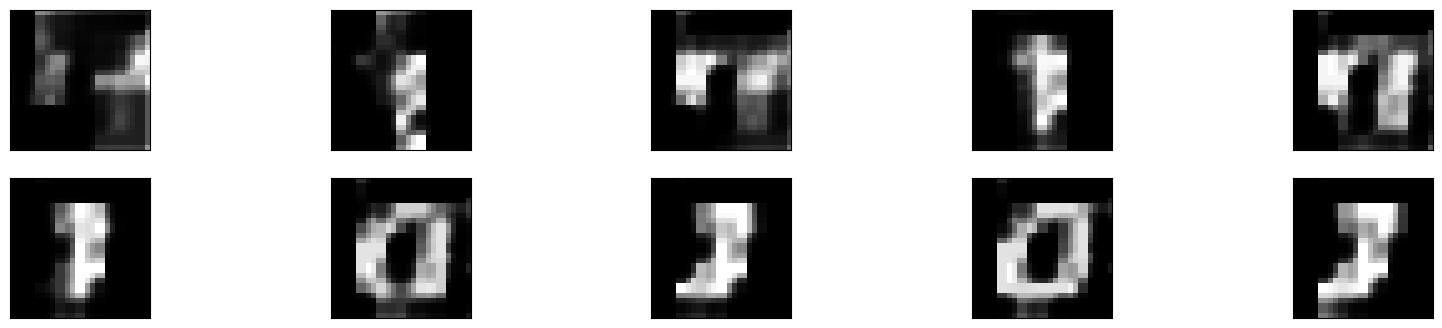

In [28]:
# plot the generated images
draw_generated_images(decoder_cnnae, 5, 2, 
                      (encoded_imgs[:, 0].min().detach().numpy(), 
                       encoded_imgs[:, 1].min().detach().numpy(), 
                       encoded_imgs[:, 0].max().detach().numpy(), 
                       encoded_imgs[:, 1].max().detach().numpy()))

## IV. CNN denoising auto-encoder

this is based on: https://blog.keras.io/building-autoencoders-in-keras.html

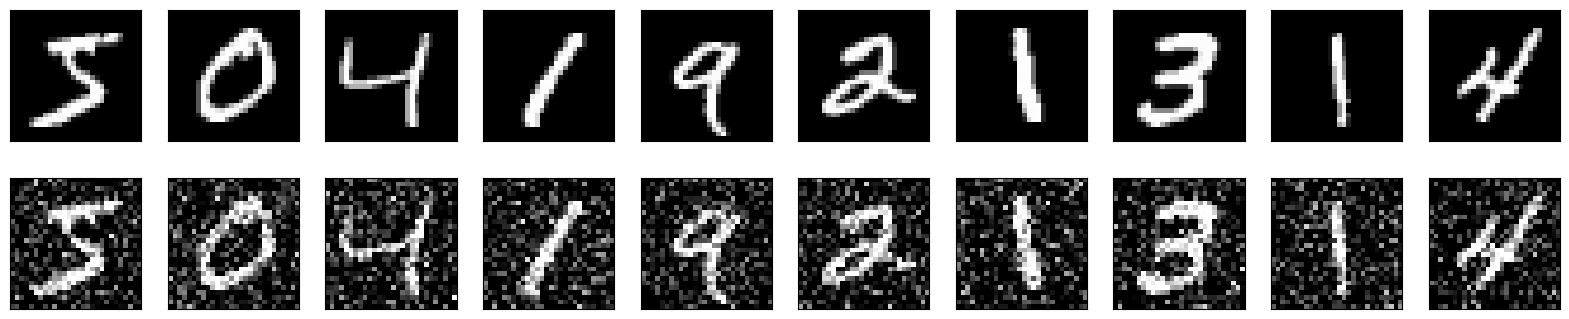

In [29]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train_noisy = x_train_noisy.float()
x_test_noisy = x_test_noisy.float()


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
denoising_ae = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3, padding=1),  # (28,28,1) -> (28,28,10)
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2, padding=0),        # (28,28,10) -> (14,14,10)
    nn.Conv2d(10, 2, kernel_size=3, padding=1),  # (14,14,10) -> (14,14,2)
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2, padding=0),         # (14,14,2) -> (7,7,2)
    # At this point the representation is (7, 7, 32)

    nn.Conv2d(2, 2, kernel_size=3, padding=1),   # (7,7,2) -> (7,7,2)
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'), # (7,7,2) -> (14,14,2)
    nn.Conv2d(2, 10, kernel_size=3, padding=1),   # (14,14,2) -> (14,14,10)
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'), # (14,14,10) -> (28,28,10)
    nn.Conv2d(10, 1, kernel_size=3, padding=1),   # (28,28,10) -> (28,28,1)
    nn.Sigmoid()
)

summary(denoising_ae, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1, 28, 28]            --
├─Conv2d: 1-1                            [1, 10, 28, 28]           100
├─ReLU: 1-2                              [1, 10, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 10, 14, 14]           --
├─Conv2d: 1-4                            [1, 2, 14, 14]            182
├─ReLU: 1-5                              [1, 2, 14, 14]            --
├─MaxPool2d: 1-6                         [1, 2, 7, 7]              --
├─Conv2d: 1-7                            [1, 2, 7, 7]              38
├─ReLU: 1-8                              [1, 2, 7, 7]              --
├─Upsample: 1-9                          [1, 2, 14, 14]            --
├─Conv2d: 1-10                           [1, 10, 14, 14]           190
├─ReLU: 1-11                             [1, 10, 14, 14]           --
├─Upsample: 1-12                         [1, 10, 28, 28]           --
├─Conv2d: 1-

In [31]:
# we can train it on a problem of regression

train_loader = DataLoader(TensorDataset(x_train_noisy, x_train), batch_size=32, shuffle=True)

denoising_ae_trainer = Trainer(denoising_ae, nn.MSELoss(), optim.Adam(denoising_ae.parameters()), classif=False)

denoising_ae_hist = denoising_ae_trainer.fit(train_loader, epochs=10)

Epoch 1/10, loss: 0.0372
Epoch 2/10, loss: 0.0215
Epoch 3/10, loss: 0.0204
Epoch 4/10, loss: 0.0200
Epoch 5/10, loss: 0.0197
Epoch 6/10, loss: 0.0195
Epoch 7/10, loss: 0.0194
Epoch 8/10, loss: 0.0192
Epoch 9/10, loss: 0.0191
Epoch 10/10, loss: 0.0190


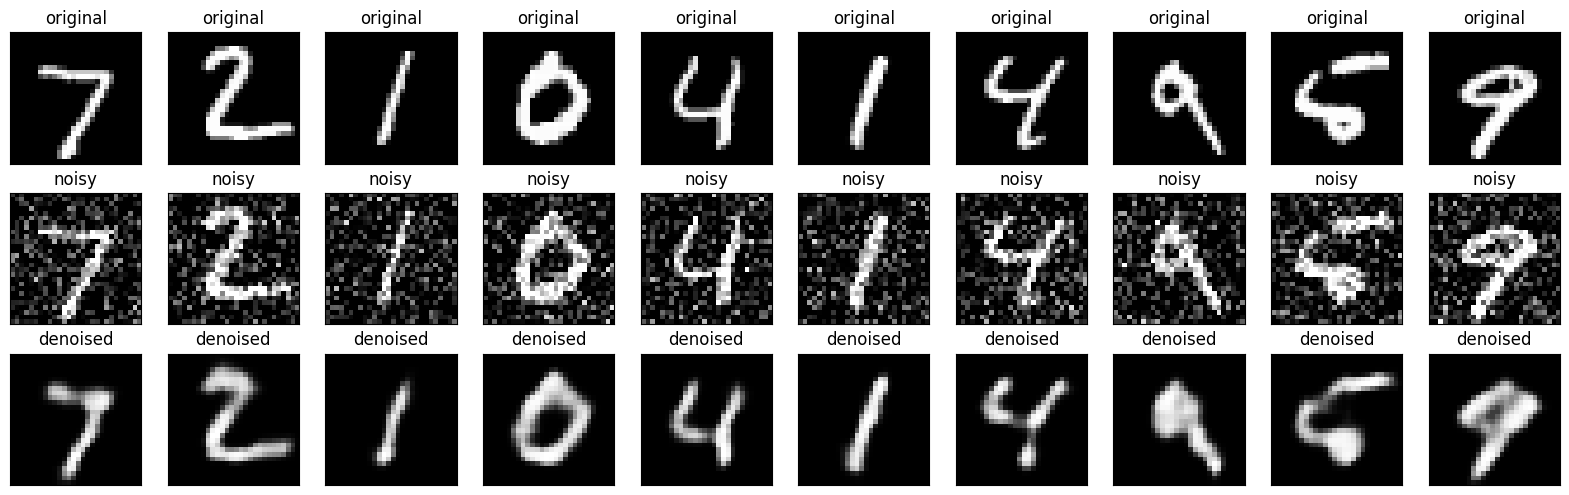

In [32]:
n = 10  # how many digits we will display
x_denoised = denoising_ae(x_test_noisy[:n, :])
plt.figure(figsize=(20, 8))
for i in range(n):
    # original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("original")
    
    # noisy
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("noisy")

    # denoised
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(x_denoised[i].reshape(28, 28).detach().numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("denoised")
    
plt.show()